# EDA: Cleaned Articles Quality Check

This notebook validates cleaned articles before indexing into ChromaDB.

**Pipeline Stage:** Between `clean.py` → `index.py`

**Validation Areas:**
1. Schema completeness
2. Text quality metrics
3. Temporal coverage
4. Source distribution
5. Language validation
6. Chunking preview
7. URL integrity
8. Content hash verification
9. Metadata richness
10. Outlier detection

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import json
import hashlib
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 1. Load Cleaned Data

In [2]:
# Load cleaned JSONL
data_path = Path('../data/processed/articles_clean.jsonl')

if not data_path.exists():
    raise FileNotFoundError(f"Data file not found: {data_path}")

df = pd.read_json(data_path, lines=True)

print(f"✓ Loaded {len(df)} articles")
print(f"✓ Columns: {list(df.columns)}")
df.head(3)

✓ Loaded 808 articles
✓ Columns: ['id', 'url', 'source', 'title', 'text', 'authors', 'published_at', 'language', 'content_hash']


,id,url,source,title,text,authors,published_at,language,content_hash
0,4f8954aaff0741049464868a7c9a284229aa5a88,https://techcrunch.com/2025/09/09/why-spacex-m...,techcrunch.com,Why SpaceX made a $17B bet on the direct-to-ce...,SpaceX just fired off one of the biggest shots...,"[Aria Alamalhodaei, Reporter, Space, Sean O'Ka...",2025-09-09 00:00:00+00:00,en,a9964e8ccf83c05e422fcb88e944a8c380d76911
1,220fd366d263f2bccf2c696100b9959091f9b08c,https://techcrunch.com/2025/09/09/apples-new-i...,techcrunch.com,Apple’s new iPhone 17 devices don’t have an AI...,"At yet another splashy event, Apple on Tuesday...","[Sarah Perez, Consumer News Editor, Sean O'Kan...",2025-09-09 00:00:00+00:00,en,68b4c43be5839aefedc9c0c394ab4cf2a2b1cf35
2,4d9e2ae347b40f953cd2811c6e2ecc67c9cf8182,https://techcrunch.com/2025/09/09/the-iphone-a...,techcrunch.com,The iPhone Air is a hint at the iPhone’s futur...,"The iPhone Air looks great with its sleek, thi...","[Sarah Perez, Consumer News Editor, Sean O'Kan...",2025-09-09 00:00:00+00:00,en,4a1f07fac3980ebf1aad6de767de03a1c99ab219


## 2. Schema Validation (§15: Metadata Schema Enforcement)

In [3]:
# Check required fields (per §15: Metadata Schema Enforcement)
required_fields = ['id', 'url', 'source', 'title', 'text', 'published_at', 'language']
optional_fields = ['authors', 'content_hash']

print("=== Required Fields Completeness ===")
missing_counts = df[required_fields].isnull().sum()
print(missing_counts)
print(f"\n✓ Articles with all required fields: {(missing_counts == 0).all()}")

# Check for empty strings (not just null)
empty_strings = df[required_fields].apply(lambda x: (x == '').sum() if x.dtype == 'object' else 0)
if empty_strings.sum() > 0:
    print(f"\n⚠️ Warning: Found {empty_strings.sum()} empty string values")
    print(empty_strings[empty_strings > 0])

# Data type validation
print("\n=== Data Types ===")
print(f"✓ published_at is string: {df['published_at'].dtype == 'object'}")
print(f"✓ language is string: {df['language'].dtype == 'object'}")

=== Required Fields Completeness ===
id                0
url               0
source            0
title             0
text              0
published_at    321
language          0
dtype: int64

✓ Articles with all required fields: False

=== Data Types ===
✓ published_at is string: False
✓ language is string: True


## 3. Text Quality Assessment (§12: Deduplication Early)

=== Text Length Statistics ===
count      808.000000
mean      5563.773515
std       7896.271294
min        303.000000
25%       1938.750000
50%       3445.500000
75%       5939.250000
max      67309.000000
Name: text_length, dtype: float64

Median text length: 3446 chars
Median word count: 567 words

⚠️ Articles <300 chars: 0 (0.0%)
⚠️ Articles <80 words: 42 (5.2%)

✓ Duplicate content_hash: 0

✓ Duplicate content_hash: 0


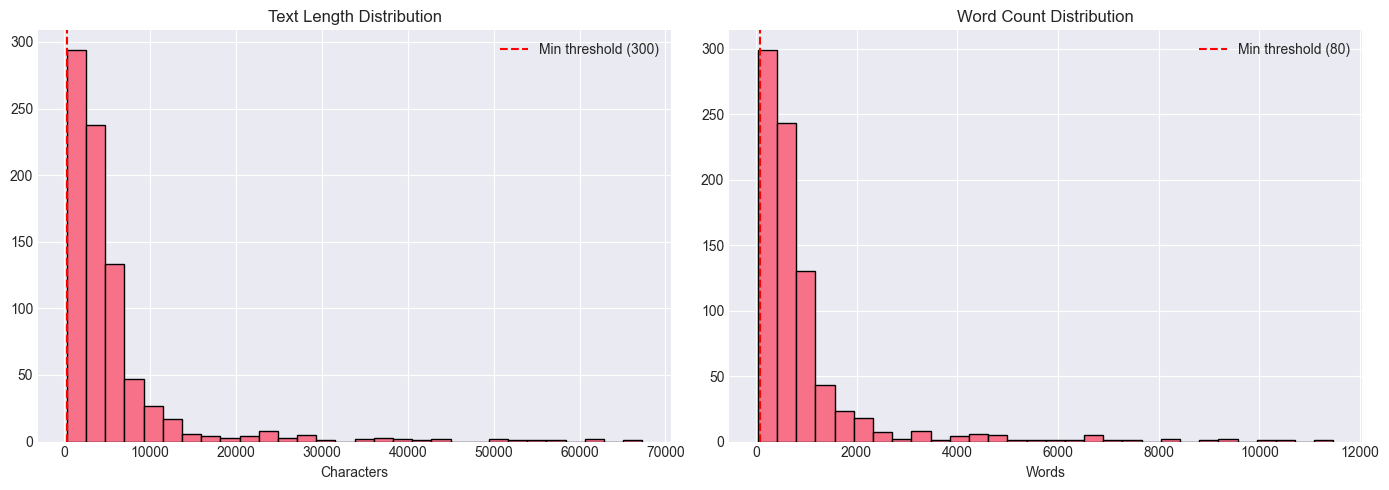

In [4]:
# Calculate text metrics
df['text_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

print("=== Text Length Statistics ===")
print(df['text_length'].describe())
print(f"\nMedian text length: {df['text_length'].median():.0f} chars")
print(f"Median word count: {df['word_count'].median():.0f} words")

# Flag problematic articles (per §12 validation rules)
short_articles = df[df['text_length'] < 300]
low_word_count = df[df['word_count'] < 80]

print(f"\n⚠️ Articles <300 chars: {len(short_articles)} ({len(short_articles)/len(df)*100:.1f}%)")
print(f"⚠️ Articles <80 words: {len(low_word_count)} ({len(low_word_count)/len(df)*100:.1f}%)")

# Check for duplicates by content_hash
if 'content_hash' in df.columns:
    duplicate_hashes = df['content_hash'].duplicated().sum()
    print(f"\n✓ Duplicate content_hash: {duplicate_hashes}")
    
# Distribution plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
df['text_length'].hist(bins=30, ax=axes[0], edgecolor='black')
axes[0].set_title('Text Length Distribution')
axes[0].set_xlabel('Characters')
axes[0].axvline(300, color='red', linestyle='--', label='Min threshold (300)')
axes[0].legend()

df['word_count'].hist(bins=30, ax=axes[1], edgecolor='black')
axes[1].set_title('Word Count Distribution')
axes[1].set_xlabel('Words')
axes[1].axvline(80, color='red', linestyle='--', label='Min threshold (80)')
axes[1].legend()
plt.tight_layout()
plt.show()

## 4. Temporal Coverage & Recency (§11: Metadata-First Retrieval)

In [5]:
# Convert to datetime
df['published_dt'] = pd.to_datetime(df['published_at'], errors='coerce')

print("=== Temporal Coverage ===")
date_range = df['published_dt'].agg(['min', 'max'])
print(f"Earliest article: {date_range['min']}")
print(f"Latest article: {date_range['max']}")
print(f"Date span: {(date_range['max'] - date_range['min']).days} days")

# Check for articles with invalid dates
invalid_dates = df[df['published_dt'].isnull()]
if len(invalid_dates) > 0:
    print(f"\n⚠️ Warning: {len(invalid_dates)} articles with invalid dates")

# Check for stale data (>365 days old per §11 auto-expand rule)
now = pd.Timestamp.now()
stale_cutoff = now - pd.Timedelta(days=365)
stale_articles = df[df['published_dt'] < stale_cutoff]
print(f"\n⚠️ Stale articles (>365 days old): {len(stale_articles)} ({len(stale_articles)/len(df)*100:.1f}%)")

# Articles per month
df_valid_dates = df[df['published_dt'].notna()].copy()
df_valid_dates['month'] = df_valid_dates['published_dt'].dt.to_period('M')
articles_per_month = df_valid_dates.groupby('month').size()

# Plot temporal distribution
fig, ax = plt.subplots(figsize=(12, 5))
articles_per_month.plot(kind='bar', ax=ax, edgecolor='black')
ax.set_title('Articles per Month')
ax.set_xlabel('Month')
ax.set_ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\n✓ Articles per month:\n{articles_per_month}")

=== Temporal Coverage ===
Earliest article: 2016-05-17 10:50:44+00:00
Latest article: 2025-09-10 00:00:00+00:00
Date span: 3402 days

⚠️ Warning: 321 articles with invalid dates


TypeError: Invalid comparison between dtype=datetime64[ns, UTC] and Timestamp

In [7]:
# Diagnose invalid dates (detailed investigation)
if len(invalid_dates) > 0:
    print(f"\n{'='*60}")
    print("INVALID DATE INVESTIGATION")
    print('='*60)
    
    print(f"\nSample invalid published_at values:")
    print(invalid_dates['published_at'].value_counts().head(10))
    
    # Check if they're all from one source
    invalid_by_source = invalid_dates['source'].value_counts()
    print(f"\nInvalid dates by source:")
    print(invalid_by_source.head(10))
    
    # Show sample articles
    print(f"\nSample invalid date articles:")
    print(invalid_dates[['title', 'published_at', 'source', 'url']].head(5))


INVALID DATE INVESTIGATION

Sample invalid published_at values:
Series([], Name: count, dtype: int64)

Invalid dates by source:
source
finance.yahoo.com          79
www.zdnet.com              69
www.businessinsider.com    68
www.ft.com                 24
www.fool.ca                14
www.nasdaq.com             13
www.fool.com                8
www.fool.co.uk              8
propertylistings.ft.com     6
www.yahoo.com               6
Name: count, dtype: int64

Sample invalid date articles:
                                                 title published_at  \
103  2017–2025 North Atlantic Right Whale Unusual M...          NaT   
108  Silicon Ranch, Central Electric partner with M...          NaT   
153                                     SEMA Coalition          NaT   
259             Ars Technica Posting Guidelines (v3.0)          NaT   
260           Amendment to Conde Nast User Agreement &          NaT   

                     source                                                url  

### 4.1 Filter Invalid Dates (Pre-Indexing Cleanup)

In [11]:
# Filter out articles with invalid dates (Option A: Recommended)
print("=== Filtering Invalid Dates ===")
print(f"Original dataset: {len(df)} articles")
print(f"Invalid dates: {len(invalid_dates)} articles ({len(invalid_dates)/len(df)*100:.1f}%)")

# Create filtered dataset
df_valid = df[df['published_dt'].notna()].copy()

print(f"\n✓ Filtered dataset: {len(df_valid)} articles")
print(f"✓ Removed: {len(df) - len(df_valid)} articles")

# Get valid article IDs
valid_ids = set(df_valid['id'].values)

# Save filtered dataset by reading original and filtering
output_path = Path('../data/processed/articles_clean_valid_dates.jsonl')
input_path = Path('../data/processed/articles_clean.jsonl')
output_path.parent.mkdir(parents=True, exist_ok=True)

# Read original and filter
count = 0
with open(input_path, 'r', encoding='utf-8') as f_in, \
     open(output_path, 'w', encoding='utf-8') as f_out:
    for line in f_in:
        article = json.loads(line)
        if article['id'] in valid_ids:
            f_out.write(line)
            count += 1

print(f"\n✅ Saved {count} articles to: {output_path}")
print(f"   Use this file for indexing to avoid date-related retrieval issues")
print(f"\n📝 Next command:")
print(f"   python -m data_pipeline.pipeline index \\")
print(f"     --input {output_path} \\")
print(f"     --cfg config/rag.yml")

=== Filtering Invalid Dates ===
Original dataset: 808 articles
Invalid dates: 321 articles (39.7%)

✓ Filtered dataset: 487 articles
✓ Removed: 321 articles

✅ Saved 487 articles to: ../data/processed/articles_clean_valid_dates.jsonl
   Use this file for indexing to avoid date-related retrieval issues

📝 Next command:
   python -m data_pipeline.pipeline index \
     --input ../data/processed/articles_clean_valid_dates.jsonl \
     --cfg config/rag.yml


## 5. Source Distribution (§11: Metadata-First Retrieval)

=== Source Distribution ===
Total unique sources: 50

Top 10 sources:
source
techcrunch.com             12.13
www.cnbc.com               12.00
finance.yahoo.com           9.78
www.zdnet.com               8.54
www.businessinsider.com     8.42
www.wired.com               6.81
www.theverge.com            6.68
arstechnica.com             6.06
www.fool.com                5.45
thenextweb.com              4.83
Name: count, dtype: float64

✓ No single source dominates (all <30%)


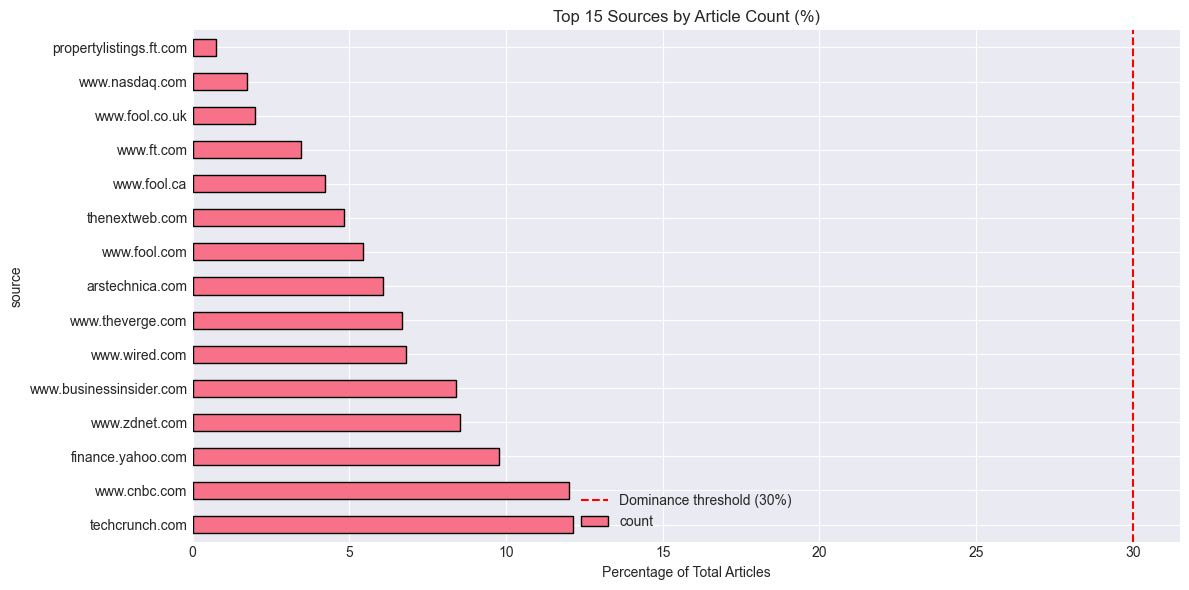

In [6]:
# Source diversity check
print("=== Source Distribution ===")
source_counts = df['source'].value_counts()
source_pct = (source_counts / len(df) * 100).round(2)

print(f"Total unique sources: {len(source_counts)}")
print(f"\nTop 10 sources:")
print(source_pct.head(10))

# Detect over-represented sources (>30% concentration)
dominant_sources = source_pct[source_pct > 30]
if len(dominant_sources) > 0:
    print(f"\n⚠️ Warning: Dominant sources (>30%):")
    print(dominant_sources)
else:
    print(f"\n✓ No single source dominates (all <30%)")

# Plot source distribution
fig, ax = plt.subplots(figsize=(12, 6))
source_pct.head(15).plot(kind='barh', ax=ax, edgecolor='black')
ax.set_title('Top 15 Sources by Article Count (%)')
ax.set_xlabel('Percentage of Total Articles')
ax.axvline(30, color='red', linestyle='--', label='Dominance threshold (30%)')
ax.legend()
plt.tight_layout()
plt.show()

## 6. Language Distribution (§15: Schema)

In [ ]:
# Language validation
print("=== Language Distribution ===")
lang_dist = df['language'].value_counts()
print(lang_dist)

# Check language code format (should be ISO 639-1: 2 chars)
invalid_lang_codes = df[df['language'].str.len() != 2]
if len(invalid_lang_codes) > 0:
    print(f"\n⚠️ Warning: {len(invalid_lang_codes)} articles with invalid language codes")
    print(invalid_lang_codes[['title', 'language']].head())
else:
    print(f"\n✓ All language codes are valid (2 chars)")

# Non-English articles
non_english = df[df['language'] != 'en']
print(f"\nNon-English articles: {len(non_english)} ({len(non_english)/len(df)*100:.1f}%)")

if len(non_english) > 0:
    print("⚠️ Note: Ensure embedding model supports these languages")
    print(non_english['language'].value_counts())

## 7. Chunking Preview (§11: Chunking Strategy)

In [ ]:
# Simulate chunking params from config/rag.yml
from langchain.text_splitter import RecursiveCharacterTextSplitter

chunk_size = 900  # from config/rag.yml
chunk_overlap = 120

splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
    length_function=len,
    separators=["\n\n", "\n", ". ", "? ", "! ", " ", ""]
)

print(f"=== Chunking Preview (size={chunk_size}, overlap={chunk_overlap}) ===")

# Test on sample articles
sample_size = min(10, len(df))
sample_texts = df.sample(sample_size)['text']
chunks_per_article = sample_texts.apply(lambda x: len(splitter.split_text(x)))

print(f"Sample size: {sample_size} articles")
print(f"Avg chunks per article: {chunks_per_article.mean():.1f}")
print(f"Median chunks: {chunks_per_article.median():.1f}")
print(f"Max chunks in sample: {chunks_per_article.max()}")

# Estimate total chunks for full corpus
estimated_total_chunks = int(chunks_per_article.mean() * len(df))
print(f"\n📊 Estimated total chunks for {len(df)} articles: ~{estimated_total_chunks}")
print(f"   (at ~1500 chunks/batch, ~{np.ceil(estimated_total_chunks/1500):.0f} batches)")

# Distribution of chunks per article
chunks_per_article.hist(bins=10, edgecolor='black', figsize=(10, 5))
plt.title('Chunks per Article Distribution (Sample)')
plt.xlabel('Number of Chunks')
plt.ylabel('Frequency')
plt.axvline(chunks_per_article.mean(), color='red', linestyle='--', label=f'Mean: {chunks_per_article.mean():.1f}')
plt.legend()
plt.show()

## 8. URL Integrity (§12: URL Normalization)

In [ ]:
# URL validation
print("=== URL Integrity ===")

# Check URL format
df['url_valid'] = df['url'].str.match(r'^https?://', na=False)
invalid_urls = df[~df['url_valid']]

print(f"Total URLs: {len(df)}")
print(f"Valid URLs (http/https): {df['url_valid'].sum()}")
print(f"Invalid URLs: {len(invalid_urls)}")

if len(invalid_urls) > 0:
    print(f"\n⚠️ Warning: Found {len(invalid_urls)} invalid URLs")
    print(invalid_urls[['title', 'url']].head())

# Check for tracking params that should've been stripped
tracking_params = ['utm_', 'mc_cid', 'mc_eid', 'ref', 'fbclid', 'gclid']
has_tracking = df['url'].str.contains('|'.join(tracking_params), regex=True, na=False)

if has_tracking.sum() > 0:
    print(f"\n⚠️ Warning: {has_tracking.sum()} URLs still contain tracking params")
    print("   This may indicate URL normalization issues")
    print(df[has_tracking][['url']].head())
else:
    print(f"\n✓ All URLs are properly normalized (no tracking params)")

# Check for duplicate URLs
duplicate_urls = df['url'].duplicated().sum()
print(f"\n{'⚠️' if duplicate_urls > 0 else '✓'} Duplicate URLs: {duplicate_urls}")

## 9. Content Hash Verification

In [ ]:
# Verify content_hash integrity (sample check)
if 'content_hash' in df.columns:
    print("=== Content Hash Verification ===")
    
    def verify_hash(row):
        """Check if content_hash matches actual text."""
        if pd.isna(row['content_hash']) or pd.isna(row['text']):
            return False
        expected = hashlib.sha1(row['text'].encode()).hexdigest()
        return row['content_hash'] == expected
    
    # Check a sample (checking all can be slow)
    sample_size = min(100, len(df))
    sample = df.sample(sample_size)
    
    hash_matches = sample.apply(verify_hash, axis=1)
    mismatches = sample[~hash_matches]
    
    print(f"Sample size: {sample_size}")
    print(f"Hash matches: {hash_matches.sum()} ({hash_matches.sum()/sample_size*100:.1f}%)")
    
    if len(mismatches) > 0:
        print(f"\n⚠️ Warning: {len(mismatches)} hash mismatches detected")
        print("   This may indicate data corruption")
    else:
        print(f"\n✓ All sampled hashes are valid")
else:
    print("⚠️ content_hash field not found in data")

## 10. Metadata Richness & Authorship

In [ ]:
# Check optional field coverage
print("=== Metadata Richness ===")

if 'authors' in df.columns:
    df['has_authors'] = df['authors'].apply(
        lambda x: len(x) > 0 if isinstance(x, list) else (pd.notna(x) and x != '')
    )
    author_coverage = df['has_authors'].mean() * 100
    print(f"Articles with authors: {df['has_authors'].sum()} ({author_coverage:.1f}%)")
else:
    print("⚠️ 'authors' field not found")

# Check for sparse metadata
sparse_metadata = df[
    (df['title'].str.len() < 20) | 
    (df['source'].isnull())
]
print(f"\nArticles with sparse metadata: {len(sparse_metadata)} ({len(sparse_metadata)/len(df)*100:.1f}%)")
if len(sparse_metadata) > 0:
    print("   (title <20 chars OR missing source)")

# Title length distribution
df['title_length'] = df['title'].str.len()
print(f"\nTitle length stats:")
print(df['title_length'].describe())

# Plot metadata completeness
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Title length
df['title_length'].hist(bins=20, ax=axes[0], edgecolor='black')
axes[0].set_title('Title Length Distribution')
axes[0].set_xlabel('Characters')
axes[0].axvline(20, color='red', linestyle='--', label='Min threshold')
axes[0].legend()

# Author coverage
if 'has_authors' in df.columns:
    df['has_authors'].value_counts().plot(kind='bar', ax=axes[1], edgecolor='black')
    axes[1].set_title('Author Field Coverage')
    axes[1].set_xticklabels(['No Authors', 'Has Authors'], rotation=0)
    axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

## 11. Outlier Detection

In [ ]:
# Detect extreme articles
print("=== Outlier Detection ===")

# Define thresholds
q01 = df['text_length'].quantile(0.01)
q99 = df['text_length'].quantile(0.99)

outliers = df[
    (df['text_length'] > q99) |  # Very long
    (df['text_length'] < q01)     # Very short
]

print(f"Outliers (1st & 99th percentile): {len(outliers)} ({len(outliers)/len(df)*100:.1f}%)")
print(f"  Very short (<{q01:.0f} chars): {len(df[df['text_length'] < q01])}")
print(f"  Very long (>{q99:.0f} chars): {len(df[df['text_length'] > q99])}")

if len(outliers) > 0:
    print(f"\nSample outliers:")
    print(outliers[['title', 'text_length', 'word_count', 'source']].head(10))
    
# Box plot for outliers
fig, ax = plt.subplots(figsize=(12, 6))
df.boxplot(column='text_length', by='source', ax=ax, rot=45)
ax.set_title('Text Length by Source (Boxplot for Outlier Detection)')
ax.set_xlabel('Source')
ax.set_ylabel('Text Length (chars)')
plt.suptitle('')  # Remove default title
plt.tight_layout()
plt.show()

## 12. Summary: Validation Report

In [ ]:
# Generate comprehensive validation report
validation_report = {
    'total_articles': len(df),
    'date_range_days': (date_range['max'] - date_range['min']).days if 'date_range' in locals() else None,
    'unique_sources': len(source_counts) if 'source_counts' in locals() else None,
    'median_text_length': int(df['text_length'].median()),
    'median_word_count': int(df['word_count'].median()),
    'short_articles_pct': round(len(short_articles) / len(df) * 100, 2) if 'short_articles' in locals() else None,
    'duplicate_hashes': duplicate_hashes if 'duplicate_hashes' in locals() else None,
    'stale_articles_pct': round(len(stale_articles) / len(df) * 100, 2) if 'stale_articles' in locals() else None,
    'invalid_urls': len(invalid_urls) if 'invalid_urls' in locals() else None,
    'non_english_pct': round(len(non_english) / len(df) * 100, 2) if 'non_english' in locals() else None,
    'estimated_total_chunks': estimated_total_chunks if 'estimated_total_chunks' in locals() else None,
    'author_coverage_pct': round(author_coverage, 2) if 'author_coverage' in locals() else None,
    'outliers_pct': round(len(outliers) / len(df) * 100, 2) if 'outliers' in locals() else None,
}

print("=" * 60)
print("VALIDATION REPORT SUMMARY")
print("=" * 60)

for key, value in validation_report.items():
    print(f"{key.replace('_', ' ').title():.<40} {value}")

# Export to CSV
report_df = pd.Series(validation_report)
report_path = '../data/processed/validation_report.csv'
report_df.to_csv(report_path, header=['value'])
print(f"\n✓ Report saved to: {report_path}")

# Decision points
print("\n" + "=" * 60)
print("DECISION POINTS")
print("=" * 60)

if 'short_articles' in locals() and len(short_articles) / len(df) > 0.05:
    print("⚠️  >5% short articles → Consider re-scraping with stricter min_chars")
    
if 'date_range' in locals() and (date_range['max'] - date_range['min']).days < 30:
    print("⚠️  Date range <30 days → Increase scraping frequency")
    
if 'source_pct' in locals() and (source_pct.max() > 50):
    print(f"⚠️  One source >{source_pct.max():.0f}% → Add more feeds to feeds.yml")
    
if 'stale_articles' in locals() and len(stale_articles) / len(df) > 0.6:
    print("⚠️  Stale articles >60% → Consider filtering before indexing")
    
if 'chunks_per_article' in locals() and chunks_per_article.mean() > 10:
    print("⚠️  Avg >10 chunks/article → Consider reducing chunk_size to 700")

print("\n✅ Ready to proceed with indexing if no critical warnings above.")

## Next Steps

After validation, proceed with indexing:

```bash
python -m data_pipeline.pipeline index \
  --input data/processed/articles_clean.jsonl \
  --cfg config/rag.yml
```

This will:
- Chunk articles (900 chars, 120 overlap)
- Generate embeddings via OpenAI
- Store in ChromaDB at `data/vdb/chroma`

In [ ]:
# Quick summary stats
print("🎯 EDA Complete!")
print(f"📊 Analyzed {len(df)} articles")
print(f"📅 Date range: {(date_range['max'] - date_range['min']).days} days" if 'date_range' in locals() else "")
print(f"🌐 Sources: {len(source_counts)}" if 'source_counts' in locals() else "")
print(f"📝 Estimated chunks: ~{estimated_total_chunks}" if 'estimated_total_chunks' in locals() else "")
print("\n✅ Review the validation report and decision points above before indexing.")